# Imports and Definitions

## Imports

In [1]:
from datetime import datetime
from glob import glob
from lzma import open as xz_open
from matplotlib import pyplot as plt
from matplotlib import rc
from os import makedirs
from seaborn import boxenplot, displot, histplot, kdeplot, lineplot, pointplot, violinplot
import matplotlib.dates as mdates

## Definitions

In [2]:
START_POS = 27894
END_POS = 28259
WINDOW_LEN = END_POS - START_POS + 1
COLOR = {
    'All':       '#AAAAAA',
    'B.1.1.7':   '#E69F00',
    'BA.5':      '#56B4E9',
    'XBB.1':     '#009E73',
    'XBB.1.5':   '#F0E442',
    'XBB.1.9.1': '#0072B2',
    'XBB.1.16':  '#D55E00',
}
START_DATE = {
    'B.1.1.7':   '2020-11-01',
    'BA.5':      '2022-04-01',
    'XBB.1':     '2022-09-01',
    'XBB.1.5':   '2022-11-01',
    'XBB.1.9.1': '2023-01-01',
    'XBB.1.16':  '2023-02-01',
}
START_DATE = {k:datetime.strptime(v,'%Y-%m-%d') for k,v in START_DATE.items()}
SKIP_LINEAGES = set()
makedirs('figs', exist_ok=True)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["legend.fontsize"] = 'large'
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams["axes.titlesize"] = 'large'
plt.rcParams["xtick.labelsize"] = 'large'
plt.rcParams["ytick.labelsize"] = 'large'

# Analysis

## Load data

In [3]:
# global data structures
del_lengths = dict() # del_lengths[lineage][label] = list of deletion lengths across sequence `label` in `lineage`
num_nucs = dict() # num_nucs[lineage][label] = number of nucleotides (non-gap) between START_POS and END_POS in sequence `label` in `lineage`
del_pos = dict() # del_pos[lineage][position] = number of deletions (gaps) at `position` in `lineage`

# parse input files
for aln_fn in glob('data/*.aln.xz'):
    lineage = aln_fn.split('/')[-1].rstrip('.aln.xz')[:-11]
    missing_date = 0; ambig_bases = 0
    if lineage in SKIP_LINEAGES:
        continue
    print("Parsing %s" % aln_fn)
    ref_row = False; label = None; curr_date = None # book-keeping for input parsing
    lin_del_lengths = dict(); lin_num_nucs = dict(); lin_del_pos = dict()
    for l in xz_open(aln_fn, 'rt'):
        # skip reference genome if in alignment
        if l.startswith('>NC_045512'):
            ref_row = True; continue
        if ref_row:
            ref_row = False; continue

        # parse this sequence
        if l.startswith('>'):
            try:
                label = l[1:].strip(); curr_date = datetime.strptime(label.split('|')[-2], '%Y-%m-%d')
            except:
                missing_date += 1; continue # ignore missing dates
        else:
            if curr_date is not None and curr_date >= START_DATE[lineage]: # skip sequences that are too old (probably incorrect collection date)
                i = START_POS; curr_del_lens = list(); curr_del_len = 0; curr_num_nucs = 0
                while i <= END_POS:
                    if l[i] == '-':
                        curr_del_len += 1
                        if i not in lin_del_pos:
                            lin_del_pos[i] = 0
                        lin_del_pos[i] += 1
                    elif l[i] == 'N' or l[i] == 'n':
                        i = None; ambig_bases += 1; break # skip sequences with N in this range
                    else:
                        curr_num_nucs += 1
                        if curr_del_len != 0:
                            curr_del_lens.append(curr_del_len); curr_del_len = 0
                    i += 1
                if i is None:
                    label = None; curr_date = None; continue # I set `i` to `None` if I need to skip this sequence (e.g. because of N)
                if curr_del_len != 0:
                    curr_del_lens.append(curr_del_len); curr_del_len = 0
                lin_del_lengths[label] = curr_del_lens
                lin_num_nucs[label] = curr_num_nucs
            label = None; curr_date = None
    del_lengths[lineage] = lin_del_lengths
    num_nucs[lineage] = lin_num_nucs
    del_pos[lineage] = lin_del_pos
    if missing_date != 0:
        print("%s missing date: %s" % (lineage, missing_date))
    if ambig_bases != 0:
        print("%s with ambiguous bases: %s" % (lineage, ambig_bases))

Parsing data/XBB.1.2023-07-27.aln.xz
XBB.1 missing date: 1293
XBB.1 with ambiguous bases: 3422
Parsing data/B.1.1.7.2023-07-27.aln.xz
B.1.1.7 missing date: 52490
B.1.1.7 with ambiguous bases: 37381
Parsing data/XBB.1.16.2023-07-27.aln.xz
XBB.1.16 missing date: 2955
XBB.1.16 with ambiguous bases: 3700
Parsing data/BA.5.2023-07-27.aln.xz
BA.5 missing date: 1235
BA.5 with ambiguous bases: 2467
Parsing data/XBB.1.5.2023-07-27.aln.xz
XBB.1.5 missing date: 11538
XBB.1.5 with ambiguous bases: 11598
Parsing data/XBB.1.9.1.2023-07-27.aln.xz
XBB.1.9.1 missing date: 2879
XBB.1.9.1 with ambiguous bases: 1184


## Create collection date distribution plots

Number of B.1.1.7 sequences: 1097307
Number of BA.5 sequences: 20883
Number of XBB.1 sequences: 22031
Number of XBB.1.16 sequences: 19119
Number of XBB.1.5 sequences: 166068
Number of XBB.1.9.1 sequences: 19990


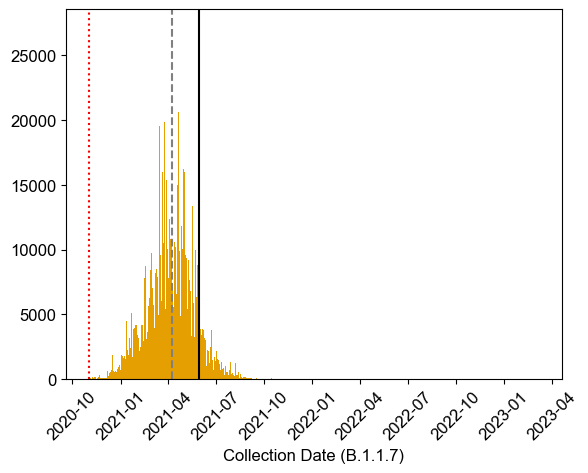

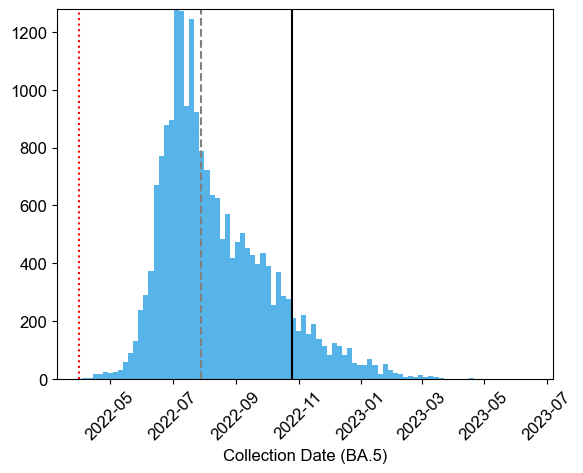

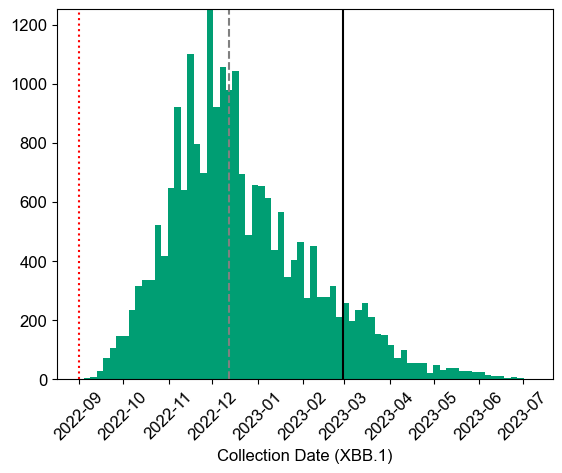

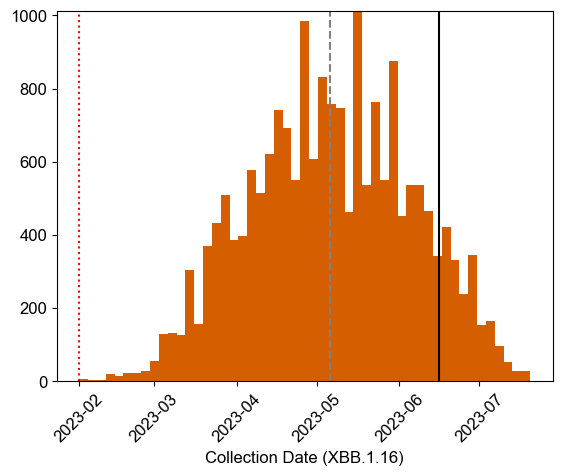

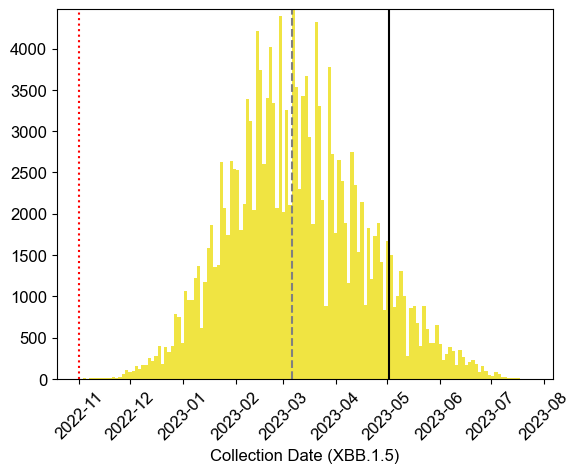

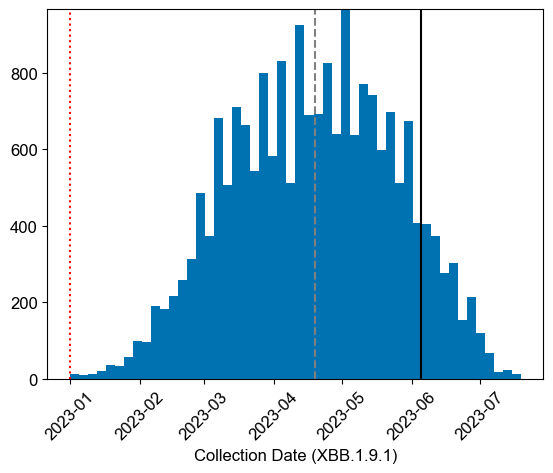

In [4]:
for lineage in sorted(del_lengths.keys()):
    dates = sorted(datetime.strptime(label.split('|')[-2], '%Y-%m-%d') for label in del_lengths[lineage])
    print("Number of %s sequences: %d" % (lineage, len(dates)))
    fig = plt.figure()
    counts, edges, bars = plt.hist(x=dates, bins='auto', color=COLOR[lineage]); max_count = max(counts)
    special_dates = [
        (START_DATE[lineage],        'Start Date',       'red',   ':'),
        (dates[int(len(dates)*0.5)], '50% of Sequences', 'grey',  '--'),
        (dates[int(len(dates)*0.9)], '90% of Sequences', 'black', '-'),
    ]
    for curr_date, curr_label, curr_color, curr_ls in special_dates:
        plt.plot([curr_date]*2, [0,max_count], color=curr_color, linestyle=curr_ls)
    plt.ylim(ymin=0, ymax=max_count)
    plt.xticks(rotation=45)
    plt.xlabel('Collection Date (%s)' % lineage)
    plt.savefig('figs/dates_hist_%s.pdf' % lineage, format='pdf', bbox_inches='tight')

## Create deletion length distribution plot

### KDE Plot

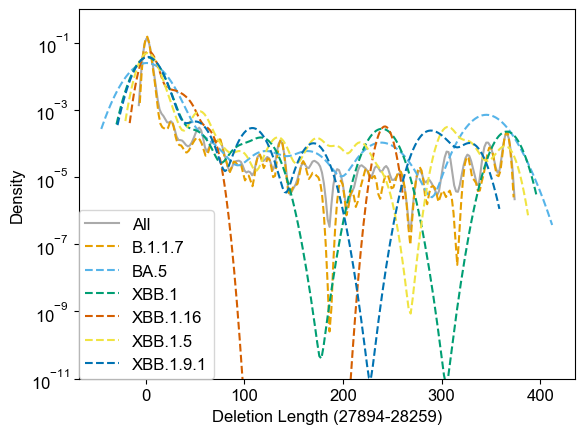

In [5]:
d = [curr_del_len for lin_del_lengths in del_lengths.values() for curr_del_lens in lin_del_lengths.values() for curr_del_len in curr_del_lens]
kdeplot(data=d, label='All', linestyle='-', color=COLOR['All'])
for lineage in sorted(del_lengths.keys()):
    d = [curr_del_len for curr_del_lens in del_lengths[lineage].values() for curr_del_len in curr_del_lens]
    kdeplot(data=d, label=lineage, linestyle='--', color=COLOR[lineage])
plt.yscale('log');
plt.ylim(ymin=10e-12, ymax=1)
plt.xlabel('Deletion Length (%s-%s)' % (START_POS, END_POS))
plt.legend(loc='best', borderaxespad=0., frameon=True)
plt.savefig('figs/deletion_length_dists_kde_%s-%s.pdf' % (START_POS, END_POS), format='pdf', bbox_inches='tight')

### Violin Plots

=== All Lineages (49350 total) ===
<10:	97.38196555217831%
10-100:	1.9412360688956434%
>100:	0.6767983789260384%

=== Lineage B.1.1.7 (43595 total) ===
<10:	98.15804564743664%
10-100:	1.3556600527583438%
>100:	0.48629429980502353%

=== Lineage BA.5 (891 total) ===
<10:	95.51066217732884%
10-100:	0.7856341189674523%
>100:	3.7037037037037037%

=== Lineage XBB.1 (520 total) ===
<10:	93.26923076923077%
10-100:	5.0%
>100:	1.7307692307692308%

=== Lineage XBB.1.16 (418 total) ===
<10:	86.60287081339713%
10-100:	12.91866028708134%
>100:	0.4784688995215311%

=== Lineage XBB.1.5 (3527 total) ===
<10:	90.67195917210094%
10-100:	7.3433512900482%
>100:	1.9846895378508647%

=== Lineage XBB.1.9.1 (399 total) ===
<10:	92.73182957393483%
10-100:	5.2631578947368425%
>100:	2.0050125313283207%



/tmp/ipykernel_912/395186968.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violinplot(x=x, y=y, palette=c, cut=0)


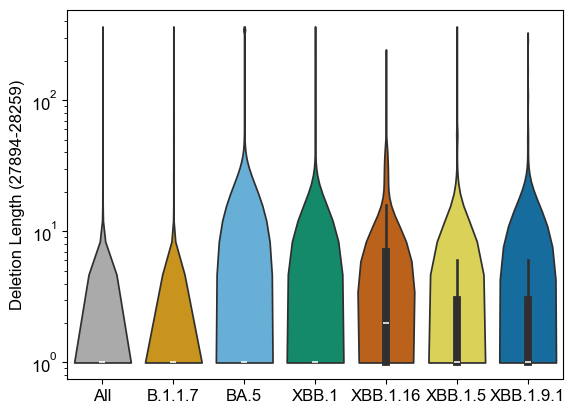

In [6]:
x = list(); y = list(); c = [COLOR['All']]
d = [curr_del_len for lineage in del_lengths for curr_del_lens in del_lengths[lineage].values() for curr_del_len in curr_del_lens]
print("=== All Lineages (%s total) ===" % len(d))
print("<10:\t%s%%" % (100.*sum(v < 10 for v in d)/len(d)))
print("10-100:\t%s%%" % (100.*sum(10<=v<=100 for v in d)/len(d)))
print(">100:\t%s%%" % (100.*sum(v > 100 for v in d)/len(d)))
print()
for lineage in sorted(del_lengths.keys()):
    c.append(COLOR[lineage])
    d = [curr_del_len for curr_del_lens in del_lengths[lineage].values() for curr_del_len in curr_del_lens]
    y += d; x += ['All']*len(d)
    y += d; x += [lineage]*len(d)
    print("=== Lineage %s (%s total) ===" % (lineage,len(d)))
    print("<10:\t%s%%" % (100.*sum(v < 10 for v in d)/len(d)))
    print("10-100:\t%s%%" % (100.*sum(10<=v<=100 for v in d)/len(d)))
    print(">100:\t%s%%" % (100.*sum(v > 100 for v in d)/len(d)))
    print()
violinplot(x=x, y=y, palette=c, cut=0)
plt.yscale('log')
plt.ylabel('Deletion Length (%s-%s)' % (START_POS, END_POS))
plt.savefig('figs/deletion_length_dists_violin_%s-%s.pdf' % (START_POS, END_POS), format='pdf', bbox_inches='tight')

### Boxen Plots

/tmp/ipykernel_912/2932176978.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxenplot(x=x, y=y, palette=c)


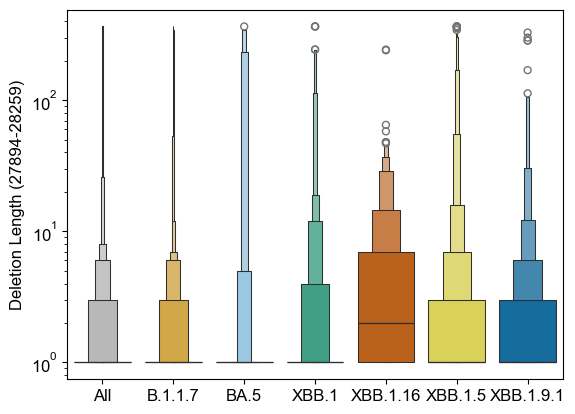

In [7]:
x = list(); y = list(); c = [COLOR['All']]
for lineage in sorted(del_lengths.keys()):
    c.append(COLOR[lineage])
    d = [curr_del_len for curr_del_lens in del_lengths[lineage].values() for curr_del_len in curr_del_lens]
    y += d; x += ['All']*len(d)
    y += d; x += [lineage]*len(d)
boxenplot(x=x, y=y, palette=c)
plt.yscale('log')
plt.ylabel('Deletion Length (%s-%s)' % (START_POS, END_POS))
plt.savefig('figs/deletion_length_dists_boxen_%s-%s.pdf' % (START_POS, END_POS), format='pdf', bbox_inches='tight')

## Create percent nucleotides vs. time plot

### Preprocess data

In [8]:
num_nucs_date = dict() # num_nucs_date[lineage][datetime] = list of num_nucs counts from sequences in `lineage` collected on `datetime`
for lineage in sorted(num_nucs.keys()):
    lin_num_nucs_date = dict()
    for label, count in num_nucs[lineage].items():
        curr_date_str = label.split('|')[-2]
        if curr_date_str.count('-') == 1:
            curr_date_str += '-01'
        elif curr_date_str.count('-') == 0:
            curr_date_str += '-01-01'
        curr_date = datetime.strptime(curr_date_str, '%Y-%m-%d')
        if curr_date not in lin_num_nucs_date:
            lin_num_nucs_date[curr_date] = list()
        lin_num_nucs_date[curr_date].append(count)
    num_nucs_date[lineage] = lin_num_nucs_date

### Line Plots

#### All Together

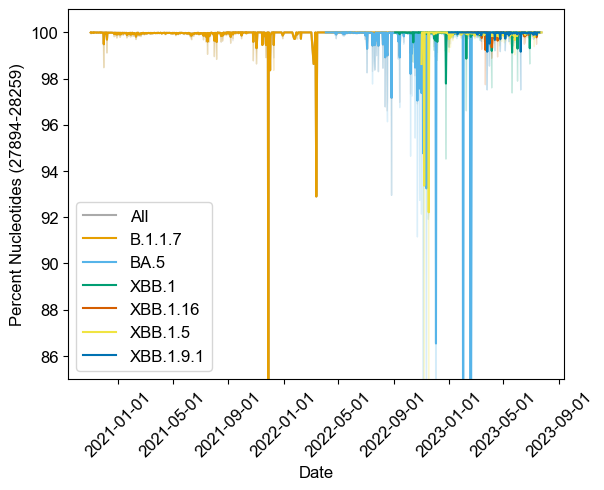

In [9]:
x = list(); y = list(); h = list(); c = [COLOR['All']]
for lineage in sorted(del_lengths.keys()):
    c.append(COLOR[lineage])
    for curr_date in sorted(num_nucs_date[lineage].keys()):
        d = [100*v/WINDOW_LEN for v in num_nucs_date[lineage][curr_date]]
        y += d; x += [curr_date]*len(d); h += ['All']*len(d)
        y += d; x += [curr_date]*len(d); h += [lineage]*len(d)
ax = lineplot(x=x, y=y, hue=h, palette=c)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.ylim(ymin=85, ymax=101)
plt.xlabel('Date')
plt.ylabel('Percent Nucleotides (%s-%s)' % (START_POS, END_POS))
plt.savefig('figs/percent_nucs_vs_time_line_%s-%s.pdf' % (START_POS, END_POS), format='pdf', bbox_inches='tight')

#### Individual Lineages

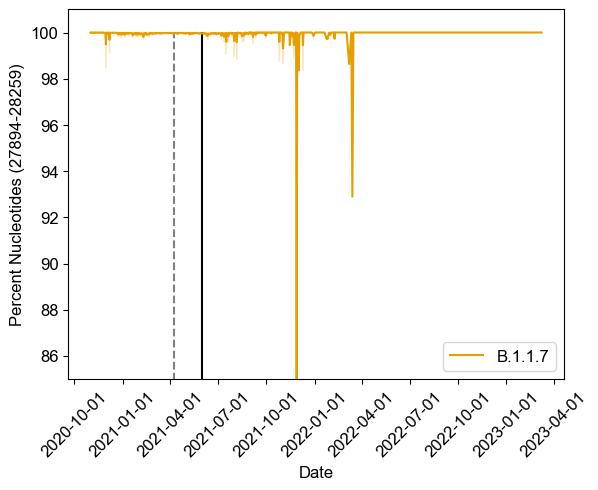

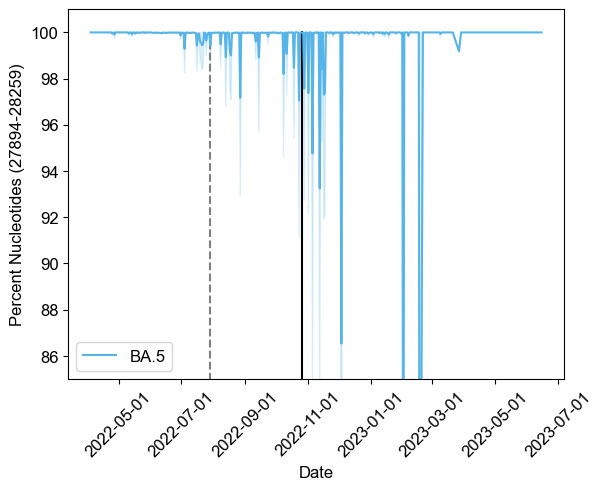

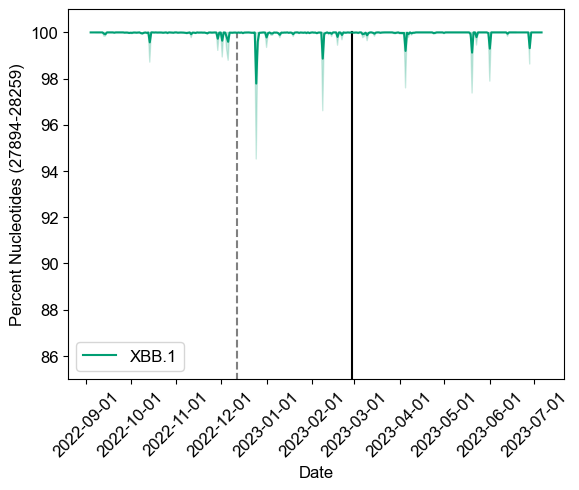

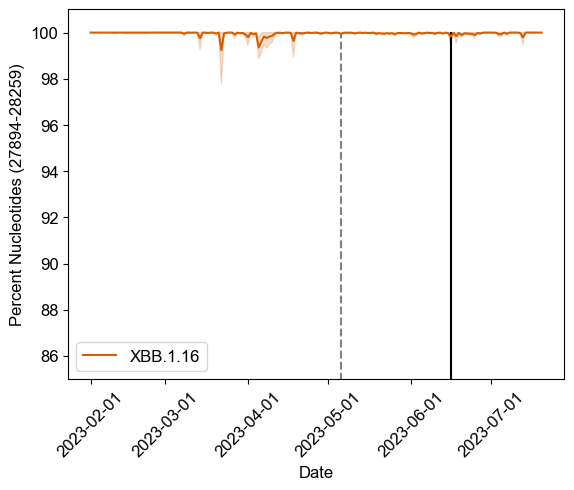

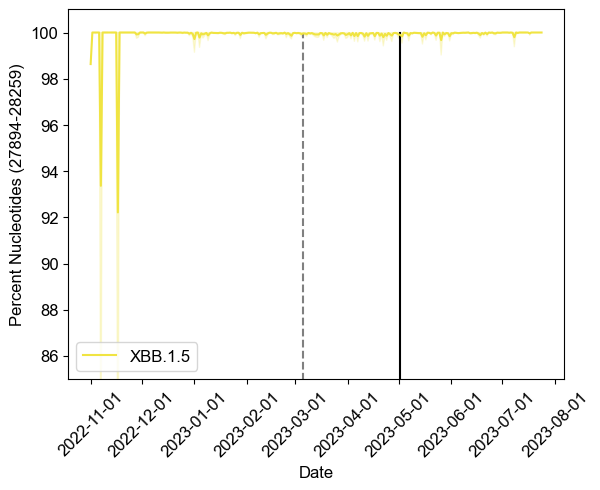

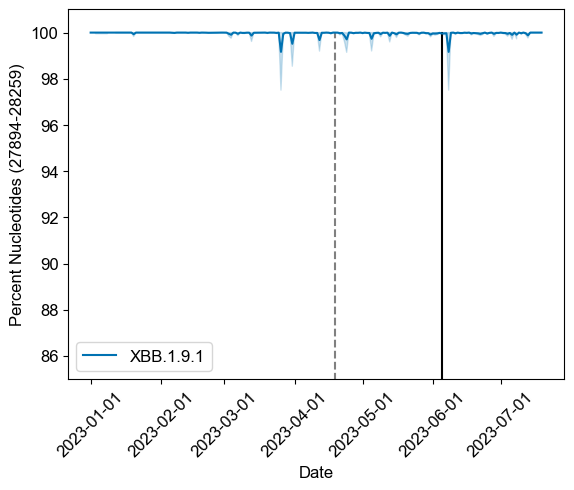

In [10]:
for lineage in sorted(del_lengths.keys()):
    fig = plt.figure(); x = list(); y = list(); h = list(); c = [COLOR[lineage]]
    for curr_date in sorted(num_nucs_date[lineage].keys()):
        d = [100*v/WINDOW_LEN for v in num_nucs_date[lineage][curr_date]]
        y += d; x += [curr_date]*len(d); h += [lineage]*len(d)
    dates = sorted(datetime.strptime(label.split('|')[-2], '%Y-%m-%d') for label in del_lengths[lineage])
    special_dates = [
        (dates[int(len(dates)*0.5)], '50% of Sequences', 'grey', '--'),
        (dates[int(len(dates)*0.9)], '90% of Sequences', 'black', '-'),
    ]
    for curr_date, curr_label, curr_color, curr_ls in special_dates:
        plt.plot([curr_date]*2, [0,100], color=curr_color, linestyle=curr_ls)
    ax = lineplot(x=x, y=y, hue=h, palette=c)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.ylim(ymin=85, ymax=101)
    plt.xlabel('Date')
    plt.ylabel('Percent Nucleotides (%s-%s)' % (START_POS, END_POS))
    plt.savefig('figs/percent_nucs_vs_time_line_%s-%s_%s.pdf' % (START_POS, END_POS, lineage), format='pdf', bbox_inches='tight')

## Create number of deletions vs. position plots

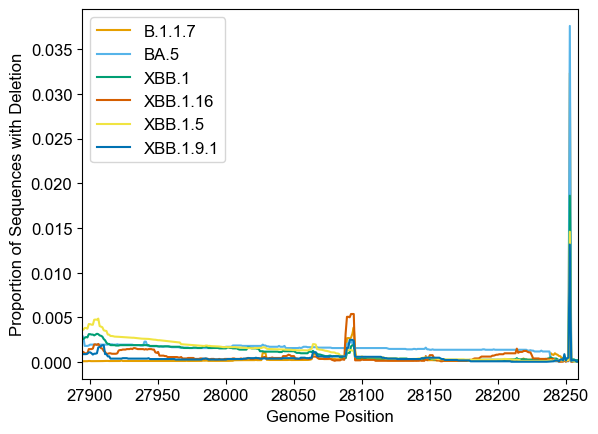

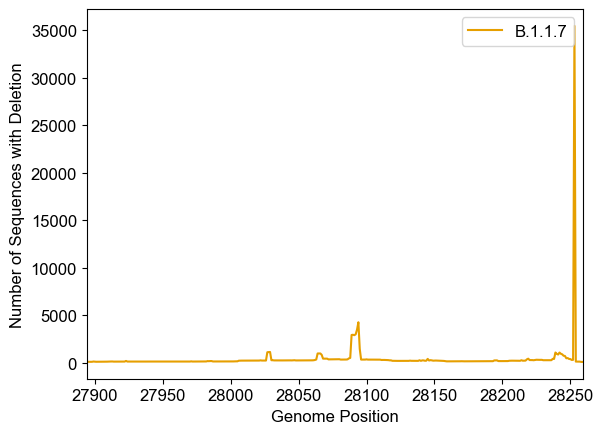

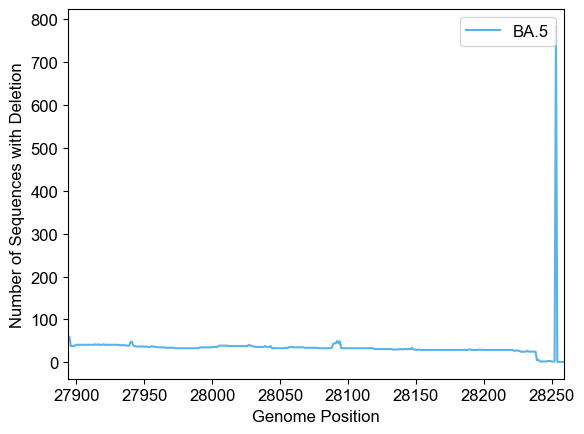

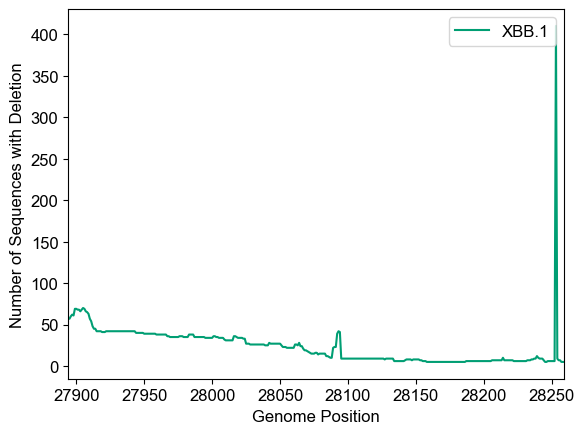

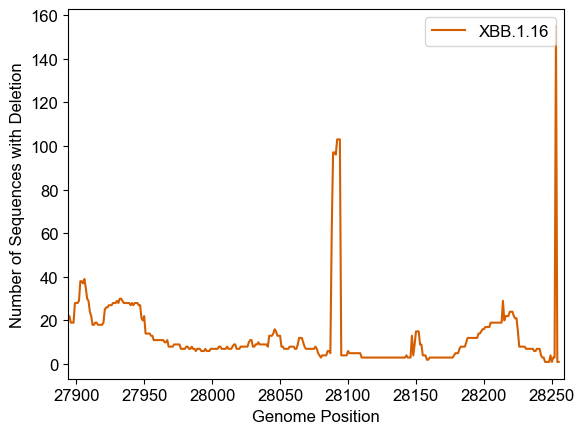

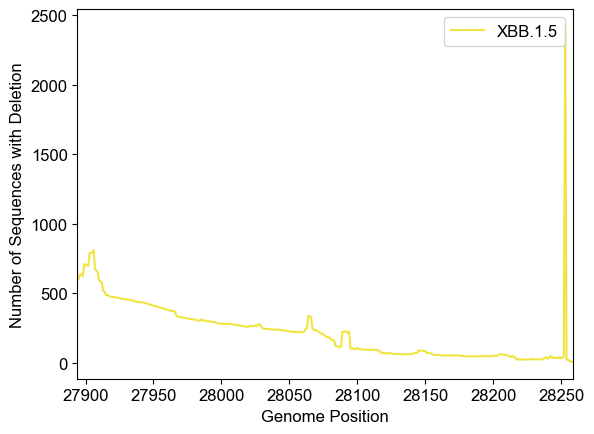

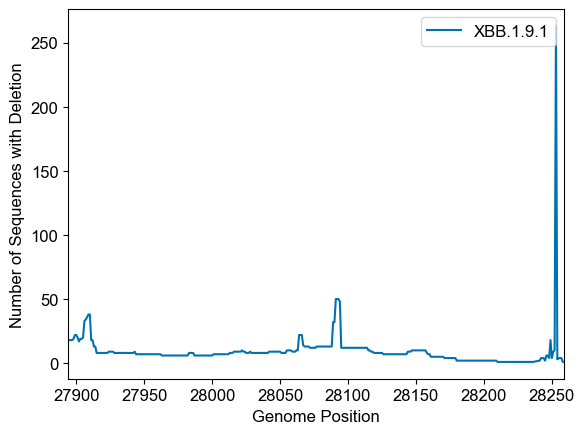

In [11]:
for lineage in ['All'] + sorted(del_pos.keys()):
    fig = plt.figure()
    if lineage == 'All':
        c = list(); x = list(); y = list(); h = list()
        for curr in sorted(del_pos.keys()):
            c.append(COLOR[curr])
            dx = sorted(del_pos[curr].keys())
            x += dx
            y += [del_pos[curr][pos]/len(num_nucs[curr]) for pos in dx] # proportion
            h += [curr]*len(dx)
    else:
        c = [COLOR[lineage]]
        x = sorted(del_pos[lineage].keys())
        y = [del_pos[lineage][pos] for pos in x] # count
        h = [lineage]*len(x)
    ax = lineplot(x=x, y=y, hue=h, palette=c)
    plt.xlim(xmin=START_POS, xmax=END_POS)
    plt.xlabel('Genome Position')
    if lineage == 'All':
        plt.ylabel('Proportion of Sequences with Deletion')
        plt.savefig('figs/gaps_vs_pos_line_%s-%s.pdf' % (START_POS, END_POS), format='pdf', bbox_inches='tight')
    else:
        plt.ylabel('Number of Sequences with Deletion')
        plt.savefig('figs/gaps_vs_pos_line_%s-%s_%s.pdf' % (START_POS, END_POS, lineage), format='pdf', bbox_inches='tight')